In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, concatenate, Flatten
from tensorflow.keras.models import Model

# Load the fashion-mnist dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize the pixel values of the images to be between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Add a channel dimension to the images
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Define the input shape
input_shape = x_train[0].shape

# Define the Inception-v1 model
def inception_v1(input_layer):
    # Path 1
    path1 = Conv2D(64, (1, 1), padding='same', activation='relu')(input_layer)
    
    # Path 2
    path2 = Conv2D(96, (1, 1), padding='same', activation='relu')(input_layer)
    path2 = Conv2D(128, (3, 3), padding='same', activation='relu')(path2)
    
    # Path 3
    path3 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_layer)
    path3 = Conv2D(32, (5, 5), padding='same', activation='relu')(path3)
    
    # Path 4
    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_layer)
    path4 = Conv2D(32, (1, 1), padding='same', activation='relu')(path4)
    
    # Concatenate the outputs of the paths
    output = concatenate([path1, path2, path3, path4], axis=3)
    
    return output

# Define the input layer
inputs = Input(shape=input_shape)

# Add the Inception-v1 layers to the model
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_v1(x)
x = inception_v1(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_v1(x)
x = inception_v1(x)
x = inception_v1(x)
x = inception_v1(x)
x = inception_v1(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = inception_v1(x)
x = inception_v1(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs, x)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/10
1875/1875 [==============================] - 75s 24ms/step - loss: 0.8564 - accuracy: 0.6427 - val_loss: 0.5062 - val_accuracy: 0.8198
Epoch 2/10
1875/1875 [==============================] - 44s 24ms/step - loss: 0.4462 - accuracy: 0.8460 - val_loss: 0.4169 - val_accuracy: 0.8539
Epoch 3/10
1875/1875 [==============================] - 44s 23ms/step - loss: 0.3737 - accuracy: 0.8711 - val_loss: 0.3679 - val_accuracy: 0.8714
Epoch 4/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.3256 - accuracy: 0.8875 - val_loss: 0.3461 - val_accuracy: 0.8821
Epoch 5/10
1875/1875 [==============================] - 46s 25ms/step - loss: 0.3016 - accuracy: 0.8935 - val_loss: 0.3130 - val_accuracy: 0.8922
Epoch 6/10
1875/1875 [==============================] - 44s 23ms/step - loss: 0.2848 - accuracy: 0.8993 - val_loss: 0.3015 - val_accuracy: 0.8979
Epoch 7/10
1875/1875 [==============================] - 44s 23ms/step - loss: 0.2755 - accuracy: 0.9031 - val_loss: 0.2999 -

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3016357421875
Test accuracy: 0.8960999846458435


In [ ]:
from keras.layers import concatenate
import tensorflow as tf

img_a_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
features = tf.keras.layers.Dense(16, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(4, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs = [img_a_feat, img_b_feat], outputs = [features], name = 'Siamese_model')
siamese_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
siamese_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 16)           336         ['merge_features[1][0

In [ ]:
import numpy as np
from PIL import Image

In [ ]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]

In [ ]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

1/1 [==============================] - 0s 314ms/step


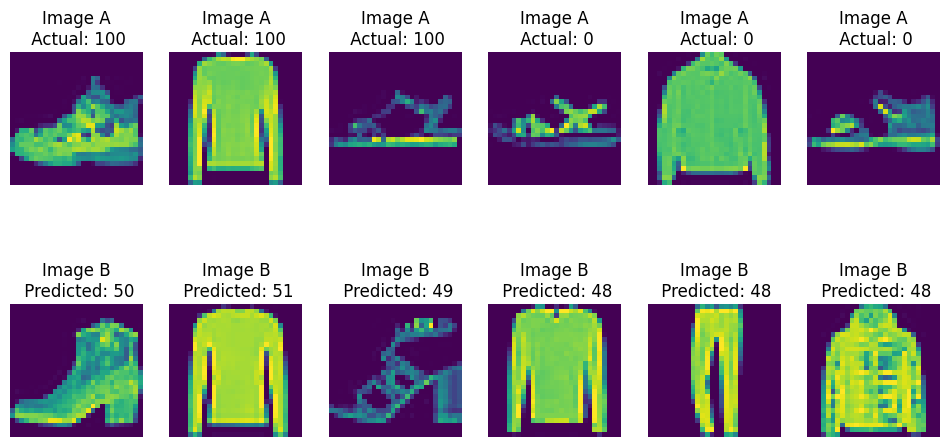

In [ ]:
import matplotlib.pyplot as plt
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title(f'Image A\n Actual: { 100 * c_d }')
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title(f'Image B\n Predicted: {int( 100 * p_d[0] )}')
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [ ]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(siam_gen(train_groups),
    steps_per_epoch = 500,
    validation_data=([model.predict(valid_a), model.predict(valid_b)],
    valid_sim),
    epochs = 4,
    verbose = True)

1/1 [==============================] - 0s 29ms/step
Epoch 1/4
500/500 [==============================] - 85s 166ms/step - loss: 0.5040 - mae: 0.3688 - val_loss: 0.3596 - val_mae: 0.2678
Epoch 2/4
500/500 [==============================] - 89s 179ms/step - loss: 0.2463 - mae: 0.1810 - val_loss: 0.2266 - val_mae: 0.1398
Epoch 3/4
500/500 [==============================] - 97s 195ms/step - loss: 0.1647 - mae: 0.1073 - val_loss: 0.2001 - val_mae: 0.1026
Epoch 4/4
500/500 [==============================] - 105s 210ms/step - loss: 0.1394 - mae: 0.0829 - val_loss: 0.2089 - val_mae: 0.0999


1/1 [==============================] - 0s 18ms/step


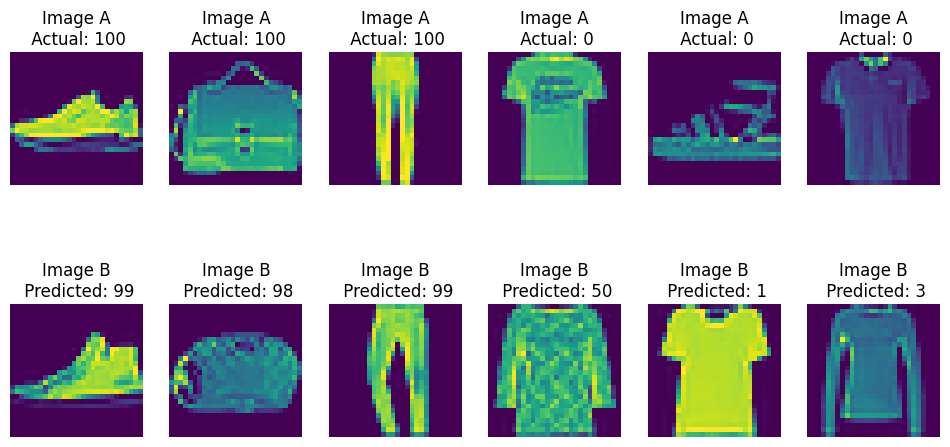

In [ ]:
_ = show_model_output()

79/79 [==============================] - 1s 7ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.017s...
[t-SNE] Computed neighbors for 10000 samples in 0.452s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.303474
[t-SNE] KL divergence afte

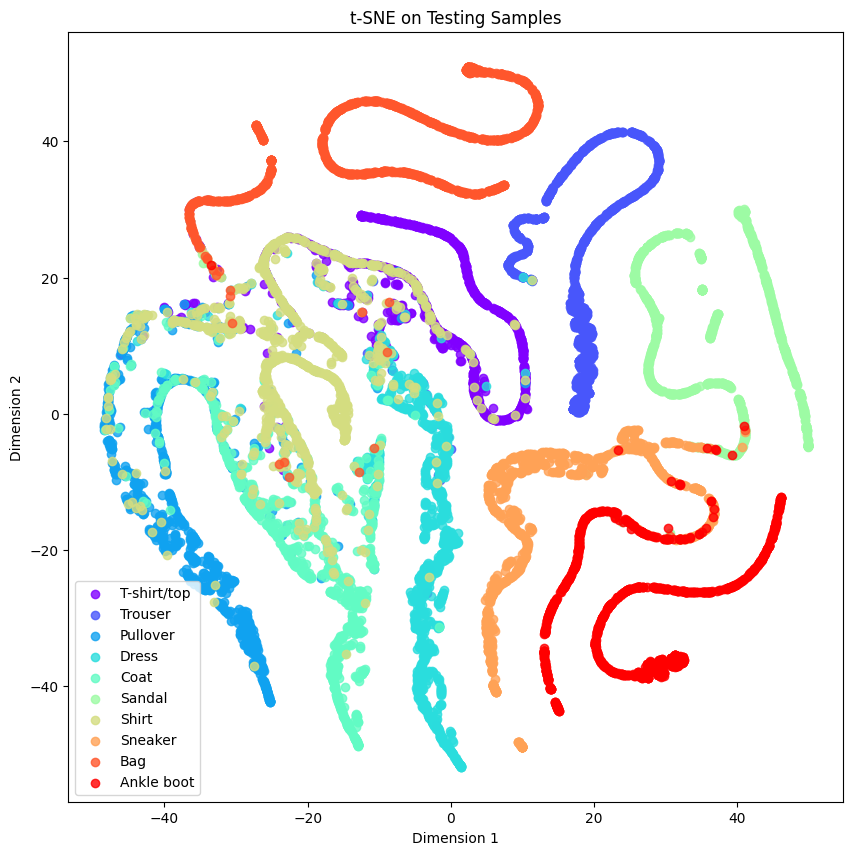

CPU times: user 1min 2s, sys: 475 ms, total: 1min 2s
Wall time: 37.2 s


In [ ]:
%%time
from sklearn.manifold import TSNE
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

obj_categories = [  
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)